# Working with ANU's global Soil Moisture product <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:**
[Global soil moisture from GPM and SMAP (10km)](http://dap.nci.org.au/thredds/remoteCatalogService?catalog=http://dapds00.nci.org.au/thredds/catalog/ub8/global/GRAFS/catalog.xml)

## Background

Soil moisture can be used to understand water availablity.

## Description
This soil moisture product is produced by the [ANU Centre for Water and Landscape Dynamics](www.wald.anu.edu.au). 
The model estimates the surface and root-zone (0-1 m) soil moisture at 10 km spatial resolution globally, using the precipitation measured by the Global Precipitation Measurement (GPM) mission and through assimilation of soil moisture product from the Soil Moisture Active/Passive (SMAP) mission.

For more information on this product, contact Luigi Renzullo <Luigi.Renzullo@anu.edu.au>

The GPM IMERG Late Precipitation data used to generate Antecedent Precipitation Index (API) were sourced from NASA Precipitation Measurement Missions (https://pmm.nasa.gov/).
The SMAP level2 enhanced radiometer half-orbit 9km data used in the assimilation were sourced from National Snow & Ice Data Centre (https://nsidc.org/).

This notebook demonstrates the following steps:
1. Retrieval of surface and root-zone wetness (as %) through NCI's THREDDS OPeNDAP service
2. Compare soil moisture to precipitation data (ERA5)
3. Compare soil moisture to land surface temperature measured by Landsat 8

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import datacube

### Analysis parameters

In [2]:
# Define the analysis region (Lat-Lon box)

# Il Ngwesi region of Kenya - Rhino Project
lat = (0.412, 0.266)
lon = (37.32, 37.40)

lat = (-33.91, -33.92)
lon = (18.42, 18.43)
# Define the time window
time = '2017-01-01', '2019-12-31'

## Retrieval of surface and root-zone wetness

In [3]:
# function to load soil moisture data

def load_soil_moisture(lat, lon, time, product = 'surface', nrt = False):
    product_baseurl = 'http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/'
    assert product in ['surface', 'rootzone'], 'product parameter must be surface or root-zone'
    # lat, lon grid
    lat_range = np.arange(np.max(np.ceil(np.array(lat)*10.+0.5)/10.-0.05), np.min(np.floor(np.array(lat)*10.-0.5)/10.+0.05)-0.05, -0.1)
    lon_range = np.arange(np.min(np.floor(np.array(lon)*10.-0.5)/10.+0.05), np.max(np.ceil(np.array(lon)*10.+0.5)/10.-0.05)+0.05, 0.1)
    # split time window into years
    day_range = np.array(time).astype("M8[D]")
    year_range = np.array(time).astype("M8[Y]")
    if product == 'surface':
        product_name = 'Surface_Wetness_from_API_'
    else: product_name = 'SWI_1m_'
    if nrt:
        product_name += 'forecast'
    else: product_name += 'analysis'
    datasets = []
    for year in np.arange(year_range[0], year_range[1]+1, np.timedelta64(1, 'Y')):
        start = np.max([day_range[0], year.astype("M8[D]")])
        end = np.min([day_range[1], (year+1).astype("M8[D]")-1])
        product_url = product_baseurl + product_name +'_window_%s.nc'%str(year)
        print(product_url)
        # data is loaded lazily through OPeNDAP
        ds = xr.open_dataset(product_url)
        # slice before return
        ds = ds.sel(lat=lat_range, lon=lon_range, time=slice(start, end)).compute()
        datasets.append(ds)
    return xr.merge(datasets)#.rename({'wetness':product})[product]

In [4]:
surface_wetness = load_soil_moisture(lat, lon, time)

http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/Surface_Wetness_from_API_analysis_window_2017.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/Surface_Wetness_from_API_analysis_window_2018.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/Surface_Wetness_from_API_analysis_window_2019.nc


In [5]:
rootzone_wetness = load_soil_moisture(lat, lon, time, product='rootzone')

http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/SWI_1m_analysis_window_2017.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/SWI_1m_analysis_window_2018.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/SWI_1m_analysis_window_2019.nc


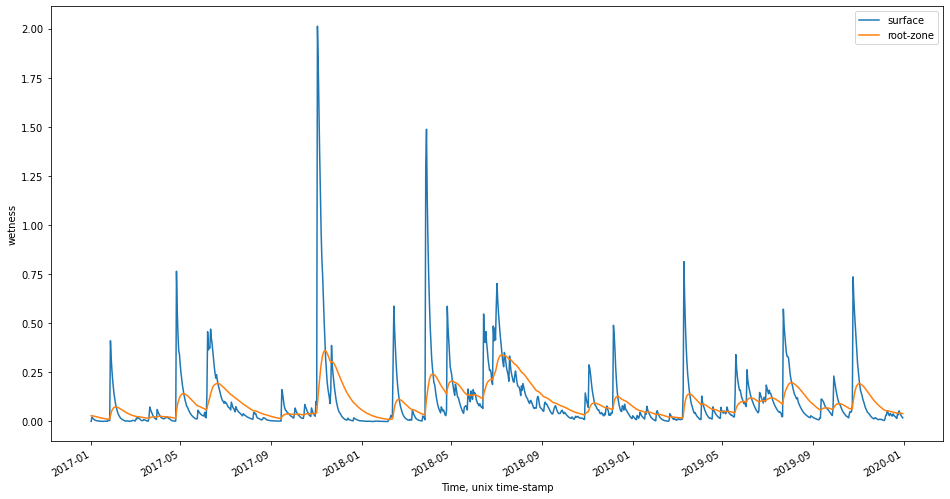

In [6]:
surface_wetness.wetness.groupby('time').mean(...).plot(figsize=(16,8), label='surface');
rootzone_wetness.wetness.groupby('time').mean(...).plot(label='root-zone');
plt.legend();

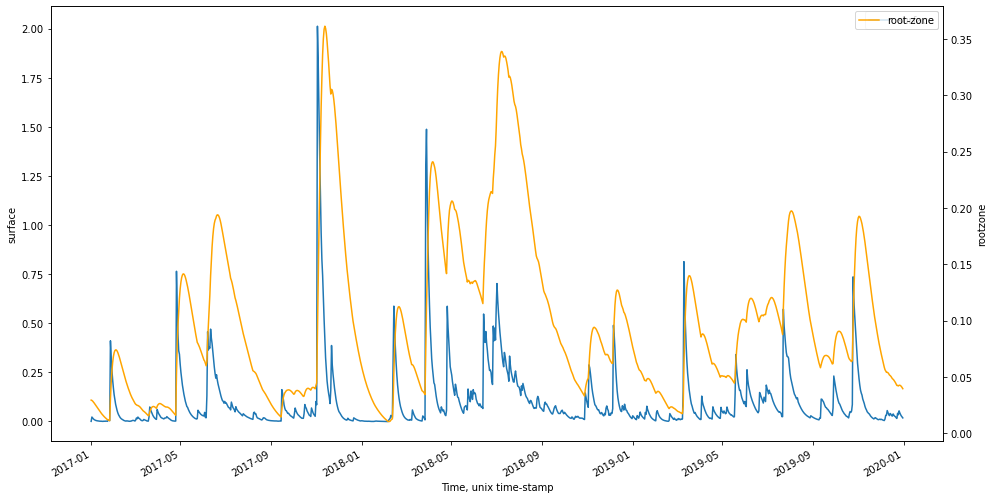

In [7]:
fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()
surface_wetness.rename({'wetness':'surface'}).surface.groupby('time').mean(...).plot(ax=ax1, label='surface');
ax1.legend();
rootzone_wetness.rename({'wetness':'rootzone'}).rootzone.groupby('time').mean(...).plot(ax=ax2, label='root-zone', color='orange');
ax2.legend();

## Compare soil moisture to precipitation data (ERA5)

In [8]:
# The following variables are available to be loaded
ERA5_VARS = [
        "air_pressure_at_mean_sea_level",
        "air_temperature_at_2_metres",
        "air_temperature_at_2_metres_1hour_Maximum",
        "air_temperature_at_2_metres_1hour_Minimum",
        "dew_point_temperature_at_2_metres",
        "eastward_wind_at_100_metres",
        "eastward_wind_at_10_metres",
        "integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation",
        "lwe_thickness_of_surface_snow_amount",
        "northward_wind_at_100_metres",
        "northward_wind_at_10_metres",
        "precipitation_amount_1hour_Accumulation",
        "sea_surface_temperature",
        "sea_surface_wave_from_direction",
        "sea_surface_wave_mean_period",
        "sea_surface_wind_wave_from_direction",
        "significant_height_of_wind_and_swell_waves",
        "snow_density",
        "surface_air_pressure",        
    ]

def get_era5_daily(var,date_from_arg,date_to_arg=None,reduce_func=None,cache_dir='era5'):
    ''' 
    Return daily values from one of the ERA5 data vars 
    NOTE: The optional reduce_func arg lets you specify a function to apply to each day's worth of data.  
    The default is np.mean, which computes daily average.  To get a sum, use np.sum
    '''
    import os, datetime
    # Massage input data
    assert var in ERA5_VARS, "var must be one of [{}] (got {})".format(','.join(ERA5_VARS), var)
    if reduce_func is None:
        import numpy as np
        reduce_func = np.mean
    from dateutil.parser import parse
    if type(date_from_arg)==str: date_from_arg = parse(date_from_arg)
    if type(date_to_arg)  ==str: date_to_arg   = parse(date_to_arg)
    if date_to_arg is None: date_to_arg = date_from_arg
    # Make sure our dates are in the correct order
    from_date = min(date_from_arg,date_to_arg)
    to_date   = max(date_from_arg,date_to_arg)
    # Download ERA5 files to local cache if they don't already exist
    client = None # Boto client (if needed)
    local_files=[] # Will hold list of local filenames
    Y,M = from_date.year, from_date.month # Loop vars
    loop_end = to_date.year*12+to_date.month # Loop sentinel
    while Y*12+M<=loop_end:
        local_file = os.path.join(cache_dir,"{Y:04}_{M:02}_{var}.nc".format(Y=Y,M=M,var=var))
        data_key = "{Y:04}/{M:02}/data/{var}.nc".format(Y=Y,M=M,var=var)
        if not os.path.isfile(local_file): # check if file already exists (TODO: move to temp?) (TODO: catch failed download)
            if client is None: 
                import boto3, botocore
                client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))
            client.download_file('era5-pds', data_key, local_file)
        local_files.append(local_file)
        if M==12: Y+=1; M=1
        else: M+=1
    # Load and merge the locally-cached ERA5 data from the list of filenames
    date_slice = slice(str(from_date.date()), str(to_date.date())) # I do this to INCLUDE the whole end date, not just 00:00

    def prepro(ds):
        if 'time0' in ds.dims: ds=ds.rename({"time0":"time"})
        if 'time1' in ds.dims: ds=ds.rename({"time1":"time"}) # This should INTENTIONALLY error if both times are defined
        return ds[[var]].sel(time=date_slice).resample(time='1D').reduce(reduce_func)
    import xarray as xr
    return xr.open_mfdataset(local_files,combine='by_coords',compat='equals',preprocess=prepro,parallel=True)

def era5_area_crop(ds,lat,lon):
    import numpy as np
    import warnings
    # Handle single value lat/lon args by wrapping them in lists
    try: min(lat)
    except TypeError: lat=[lat]
    try: min(lon)
    except TypeError: lon=[lon]
    # We do NOT handle longitude wraparound - user should merge multiple calls to this function instead.
    # Technically the code will work with values outside the range, it will just round to the closest within range.
    # Since rounding -180 up to 0 may not be the expected behavior, issue warnings if args outside range.
    if min(lat) < ds.lat.min() or max(lat) > ds.lat.max():
        warnings.warn("Lats must be in range {} .. {}.  Got: {}".format(ds.lat.min().values,ds.lat.max().values,lat))
    if min(lon) < ds.lon.min() or max(lon) > ds.lon.max():
        warnings.warn("Lons must be in range {} .. {}.  Got: {}".format(ds.lon.min().values,ds.lon.max().values,lon))
    # Find existing coords between min&max
    lats = ds.lat[np.logical_and(ds.lat>=min(lat),ds.lat<=max(lat))].values 
    # If there was nothing between, just plan to grab closest
    if len(lats)==0: 
        lats = np.unique(ds.lat.sel(lat=np.array(lat), method="nearest"))        
    lons = ds.lon[np.logical_and(ds.lon>=min(lon),ds.lon<=max(lon))].values
    if len(lons)==0: 
        lons = np.unique(ds.lon.sel(lon=np.array(lon), method="nearest"))        
    return ds.sel(lat=lats,lon=lons)


def load_era5(var, lat, lon, time, **kwargs):
    ds = get_era5_daily(var,time[0],time[1], **kwargs)
    return era5_area_crop(ds, lat, lon)

In [9]:
# Define the selected variables
# If you want more variables, add them here and then code at the bottom for additional plots of the new variable
var_precipitation = 'precipitation_amount_1hour_Accumulation'
precipitation = load_era5(var_precipitation, lat, lon, time, reduce_func=np.sum).compute()

# Convert from Meters (m) to Millimeters (mm)
precipitation[var_precipitation]=precipitation[var_precipitation]*1000

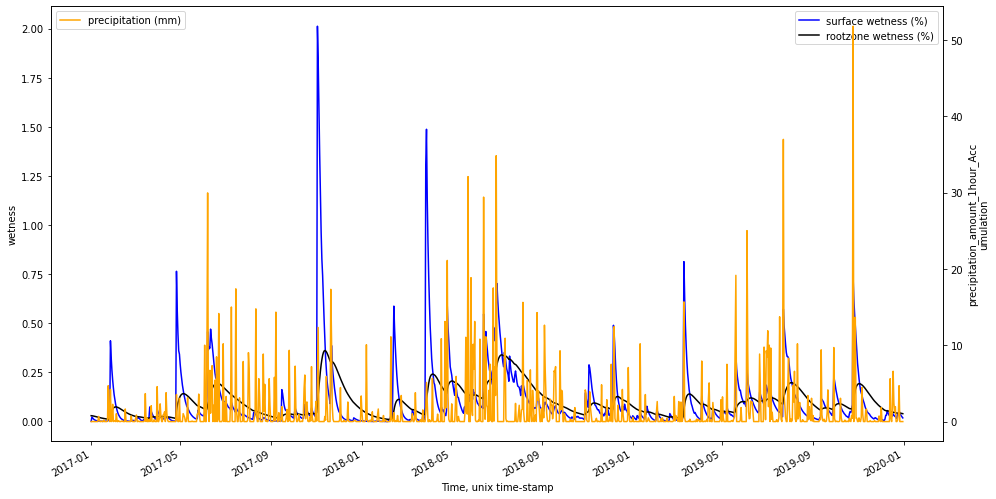

In [10]:
fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()
surface_wetness.wetness.groupby('time').mean(...).plot(ax = ax1, label = 'surface wetness (%)', color = 'blue');
rootzone_wetness.wetness.groupby('time').mean(...).plot(ax = ax1, label = 'rootzone wetness (%)', color = 'black');
precipitation[var_precipitation].groupby('time').mean(...).plot(ax = ax2, label = 'precipitation (mm)', color = 'orange');
ax1.legend();
ax2.legend();

## Compare soil moisture to land surface temperature measured by Landsat 8

In [11]:
dc = datacube.Datacube()

In [12]:
lat_range = surface_wetness.lat[0], surface_wetness.lat[-1]
lon_range = surface_wetness.lon[0], surface_wetness.lon[-1]
data = dc.load(product='usgs_ls8c_level2_2', lat=lat_range, lon=lon_range, time=time, 
               measurements = ['surface_temperature', 'thermal_radiance', 'emissivity'],
               output_crs = 'epsg:4326', resolution=(-0.1, 0.1), resampling='average')

In [13]:
good_lst = data.surface_temperature.where(data.surface_temperature!=data.surface_temperature.attrs['nodata'], drop=True)

In [14]:
good_lst.min()

<xarray.DataArray 'surface_temperature' ()>
array(27451.)

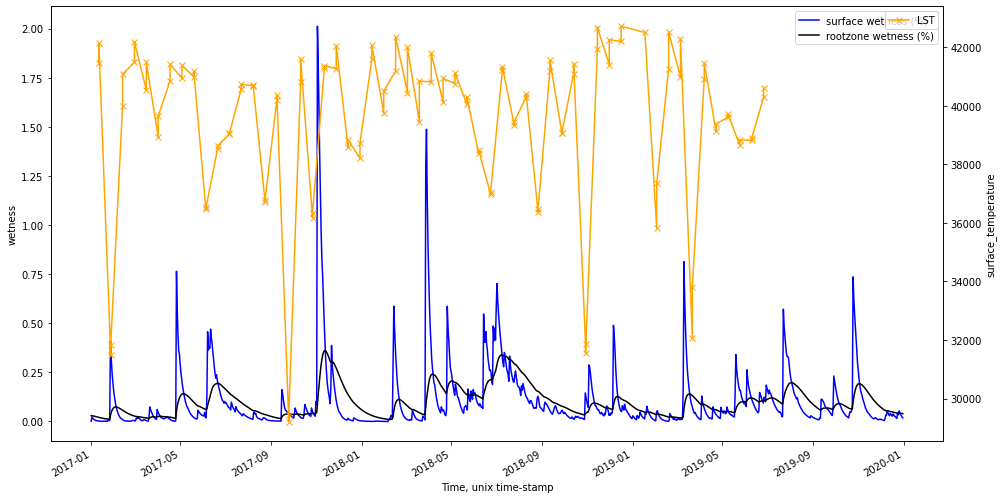

In [17]:
fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()
surface_wetness.wetness.groupby('time').mean(...).plot(ax = ax1, label = 'surface wetness (%)', color = 'blue');
rootzone_wetness.wetness.groupby('time').mean(...).plot(ax = ax1, label = 'rootzone wetness (%)', color = 'black');
good_lst.groupby('time').mean(...).plot(ax = ax2, label = 'LST', color = 'orange', marker='x');
#ax2.set_ylim((40000,55000))
ax1.legend()
ax2.legend();

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** March 2020

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.7+262.g1cf3cea8


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)

**Tags**:  :index:`soil moisture`, :index:`era5`, :index:`climate`, :index:`land surface temperature`